# Social Media Analytics (Twitter US Airlines Sentiment Case)

### Zumarsiyah Mahsyari
##### Astra Data Scientist Bootcamp

Social media analytics adalah salah satu metode yang dapat digunakan untuk mengetahui tingkat awareness dan kebutuhan pelanggan terhadap layanan produk perusahaan.

Pada Practice Case kali ini kita menggunakan dataset Twitter US Airline Sentiment. Data ini berisi tanggapan traveler terhadap airline di US melalui Twitter.

In [35]:
import pandas as pd 
import numpy as np 
import nltk 
#import nltk for natural language toolkit
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

### Load & Read Data

In [26]:
df = pd.read_csv("C:/Users/zumars064124/Documents/ADSB 2/Text Mining/tweets.csv")
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14480,570309308937842688,neutral,0.6869,NaN,NaN,Delta,NaN,Oneladyyouadore,NaN,0,@JetBlue I hope so because I fly very often an...,NaN,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,NaN,NaN,US Airways,NaN,DebbiMcGinnis,NaN,0,@USAirways is a DM possible if you aren't foll...,NaN,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,NaN,NaN,Delta,NaN,jaxbra,NaN,0,@JetBlue Yesterday on my way from EWR to FLL j...,NaN,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,GAKotsch,NaN,0,@USAirways and when will one of these agents b...,NaN,2015-02-24 11:51:48 -0800,NaN,Atlantic Time (Canada)
14484,570310600460525568,negative,0.6292,Flight Booking Problems,0.3146,US Airways,NaN,jhazelnut,NaN,0,@USAirways is there a better time to call? My...,NaN,2015-02-24 11:53:37 -0800,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
tweet_id                        14485 non-null int64
airline_sentiment               14485 non-null object
airline_sentiment_confidence    14485 non-null float64
negativereason                  9082 non-null object
negativereason_confidence       10416 non-null float64
airline                         14485 non-null object
airline_sentiment_gold          40 non-null object
name                            14485 non-null object
negativereason_gold             32 non-null object
retweet_count                   14485 non-null int64
text                            14485 non-null object
tweet_coord                     1007 non-null object
tweet_created                   14485 non-null object
tweet_location                  9798 non-null object
user_timezone                   9710 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Data terdiri dari data kategori dan numerik.

In [5]:
df.shape

(14485, 15)

In [ ]:
Data terdiri dari 14.485 baris dan 15 kolom.

In [6]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5403
negativereason_confidence        4069
airline                             0
airline_sentiment_gold          14445
name                                0
negativereason_gold             14453
retweet_count                       0
text                                0
tweet_coord                     13478
tweet_created                       0
tweet_location                   4687
user_timezone                    4775
dtype: int64

Terdapat missing value pada data. Karena kita hanya melakukan analisis eksplorasi data, maka kita tidak perlu melakukan sesuatu terhadap missing value tersebut.

Mari kita liat sentiment traveler terhadap airlines di US.

### Traveler Sentiment Airlines

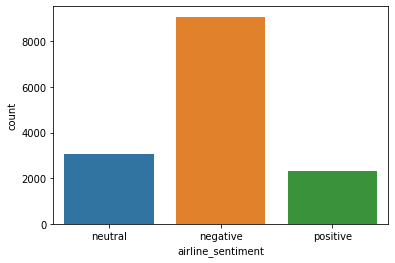

In [10]:
sns.countplot(x = df.airline_sentiment)

Sentiment pelanggan terbagi atas sentimen negatif, positif, dan netral. Berdasarkan visualisasi di atas, diketahui bahwa sentimen yang paling banyak diberikan adalah sentimen negatif. Mari kita buat wordcloud untuk memahami respon customer terhadap sentimen negatif dan positif.

### Wordcloud of Traveler Sentiment Airlines

In [47]:
#Preprocessing for building wordcloud
#cleansing 
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

#apply function 
df['text'] = df['text'].progress_apply(preprocessing)

#stopword 
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#lematization 
df['text']  = df['text'] .apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

#define negative and positive 
negative = df.loc[df['airline_sentiment'] == "negative"]
positive  = df.loc[df['airline_sentiment'] == "positive"]

#merge all the happy comments into one paragraph
all_description_negative = "".join(negative.text.values)
all_description_positive = "".join(positive.text.values)

#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 14485/14485 [00:01<00:00, 7562.76it/s]


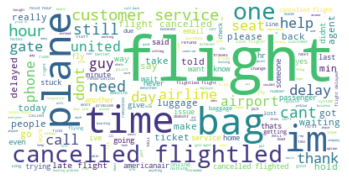

In [44]:
#negative sentiment wordcloud
create_word_cloud(all_description_negative)

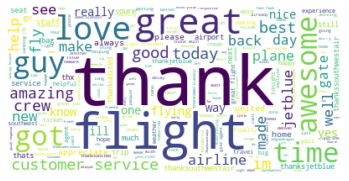

In [45]:
#positive sentiment
create_word_cloud(all_description_positive)

Karena banyaknya sentimen negatif yang diberikan, mari kita telusuri alasan di balik sentimen tersebut.

### Reason of Negative Sentiment

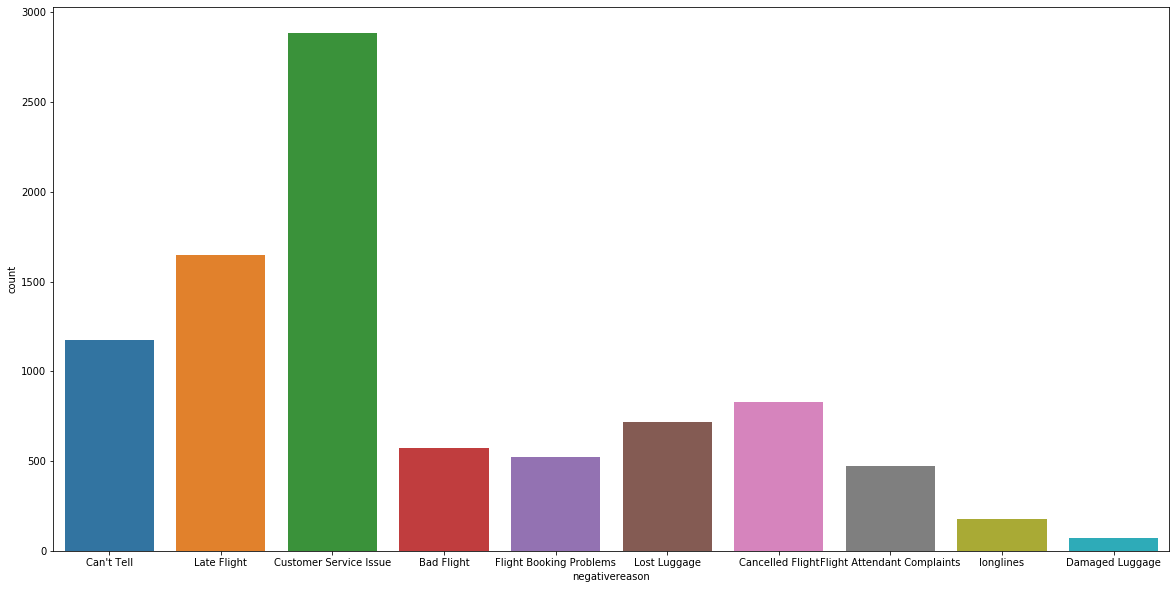

In [19]:
fig, ax = plt.subplots(figsize = (20,15))
fig.set_size_inches(20, 10)
sns.countplot(x = df.negativereason)

Berdasarkan visualisasi di atas, customer servise issue merupakan alasan yang paling banyak menyebabkan sentimen negatif. Mari kita telusuri lebih lanjut terkait customer servise issue.

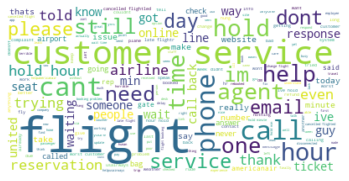

In [99]:
#define cs_issue 
negative = df.loc[df['airline_sentiment'] == "negative"]
csissue  = negative.loc[negative['negativereason'] == "Customer Service Issue"]

#merge all the negative because of customer issue into one paragraph
all_description_csissue = "".join(csissue.text.values)

#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
#negative sentiment because of customer service issue wordcloud
create_word_cloud(all_description_csissue)

Berdasarkan visualisasi wordcloud di atas, traveler banyak membahas terkait respon, reservasi, waktu, dan lain sebagainya. Hal-hal ini dapat dijadikan bahan evaluasi bagi pihak manajemen airlines untuk mengatasi customer servise issue.

Mari kita bandingkan tanggapan traveler berdasarkan merek airlines melalui tweet mereka.

### Sentiment Based on Airlines

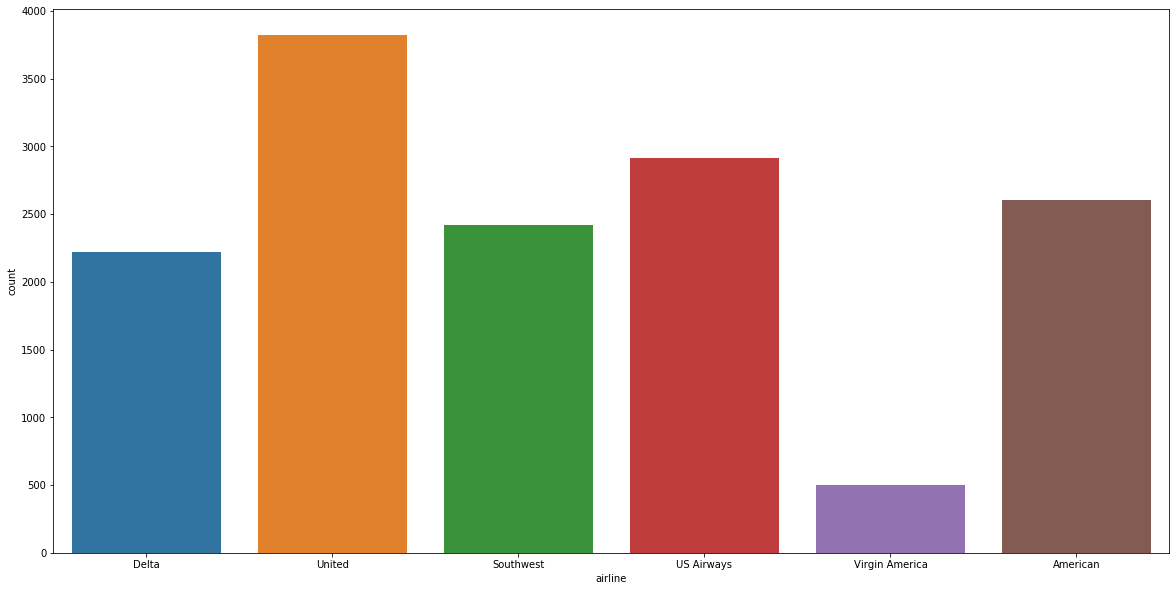

In [58]:
fig, ax = plt.subplots(figsize = (20,15))
fig.set_size_inches(20, 10)
sns.countplot(x = df.airline)

Berdasarkan visualisasi di atas, airline yang paling banyak dibahas oleh traveler melalui twitter adalah United. Mari kita lihat perbandingan airline berdasarkan sentimen negatif dan positif.

In [88]:
#count sentiment
negative = df[df.airline_sentiment == 'negative']
positive = df[df.airline_sentiment == 'positive']
airline_negative = negative.groupby(['airline'])['airline'].count()
airline_positive = positive.groupby(['airline'])['airline'].count()
airline = df.groupby(['airline'])['airline'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(airline)
chartnegative = pd.DataFrame(airline_negative)
chartpositive = pd.DataFrame(airline_positive)
chart['tweet_count'] = chart['airline']
chart['tweet_countnegative'] = chartnegative
chart['tweet_countpositive'] = chartpositive
chart.drop(['airline'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent_negative'] = chart['tweet_countnegative']/chart['tweet_count']
chart['percent_positive'] = chart['tweet_countpositive']/chart['tweet_count']
chart

,airline,tweet_count,tweet_countnegative,tweet_countpositive,percent_negative,percent_positive
0,American,2604,1864,307,0.715822,0.117896
1,Delta,2222,955,544,0.429793,0.244824
2,Southwest,2420,1186,570,0.490083,0.235537
3,US Airways,2913,2263,269,0.776862,0.092345
4,United,3822,2633,492,0.688906,0.128728
5,Virgin America,504,181,152,0.359127,0.301587


### Negative Sentiment Based on Airlines

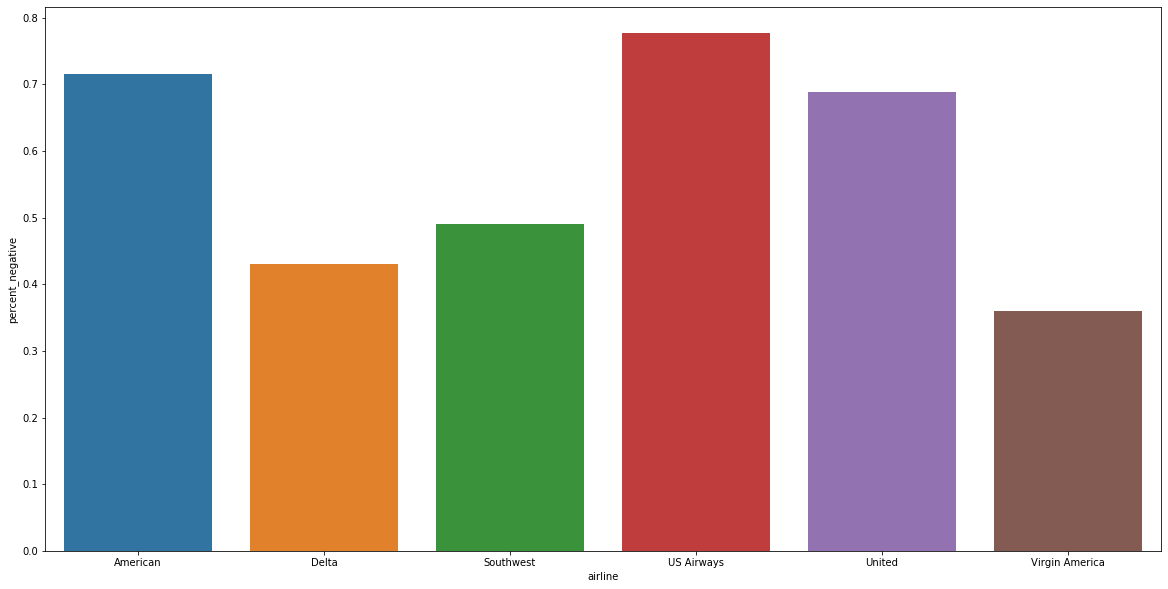

In [87]:
fig, ax = plt.subplots(figsize = (20,15))
fig.set_size_inches(20, 10)
sns.barplot(x = chart.airline, y = chart.percent_negative)

US Airways merupakan airline yang banyak dibahas melalui twitter oleh traveler setelah United. Ternyata, 77,69% tweet traveler tentang US Airways merupakan sentimen negatif, sedangkan tweet tentang United 68,89% di antaranya merupakan sentimen negatif.

Mari kita lihat wordcloud untuk sentimen negatif pada US Airways dan United.

##### Wordcloud of Negative Sentiment US Airways

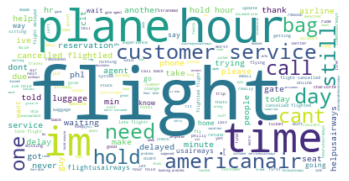

In [92]:
#define negative sentiment US Airways
negative = df.loc[df['airline_sentiment'] == "negative"]
USAirwaysnegative  = negative.loc[negative['airline'] == "US Airways"]

#merge all the negative because of customer issue into one paragraph
all_description_USAirwaysnegative = "".join(USAirwaysnegative.text.values)

#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
#negative sentiment US Airways
create_word_cloud(all_description_USAirwaysnegative)

Traveler yang memiliki sentimen negatif terhadap US Airways, melalui twitter mereka membahas terkait flight (penerbangan), plane hour (jam penerbangan), customer service, dan lain sebagainya. Hal-hal tersebut dapat ditinjau kembali oleh pihak manajemen US Airways untuk meminimalisir sentimen negatif para traveler.

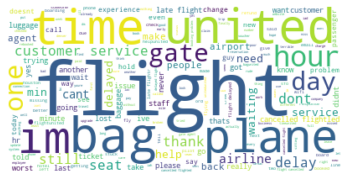

In [93]:
#define negative sentiment United
negative = df.loc[df['airline_sentiment'] == "negative"]
Unitednegative  = negative.loc[negative['airline'] == "United"]

#merge all the negative because of customer issue into one paragraph
all_description_Unitednegative = "".join(Unitednegative.text.values)

#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
#negative sentiment US Airways
create_word_cloud(all_description_Unitednegative)

Hal-hal yang menjadi bahasan para traveler yang memiliki sentimen negatif terhadap United melalui twitter antara lain time (waktu), plane (pesawat), flight (penerbangan), dan lain sebagainya. Hal-hal tersebut dapat ditinjau kembali oleh pihak manajemen United untuk meminimalisir sentimen negatif para traveler.

### Positive Sentiment Based on Airlines

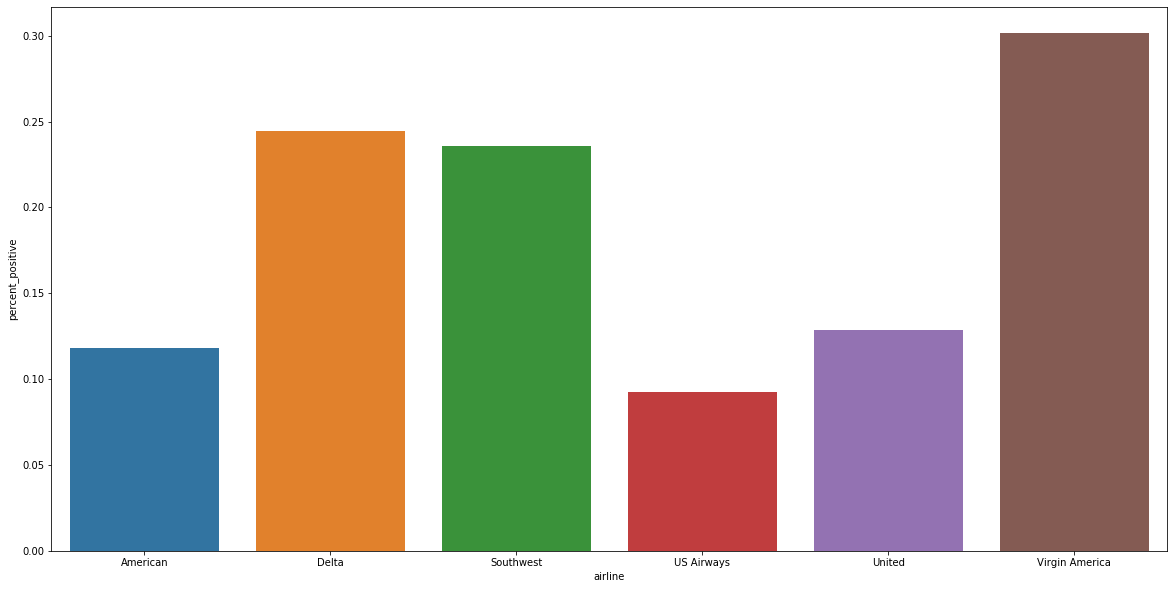

In [89]:
fig, ax = plt.subplots(figsize = (20,15))
fig.set_size_inches(20, 10)
sns.barplot(x = chart.airline, y = chart.percent_positive)

Virgin America merupakan airline yang paling sedikit dibahas oleh traveler melalui twitter. Akan tetapi, 30,16% tweet yang membahas tentang Virgin America merupakan sentimen positif. Berbeda dengan United, meskipun United merupakan airline yang paling banyak dibahas oleh traveler melalui twitter, hanya 12,87% saja tweet di antaranya yang merupakan sentimen positif.

Mari kita lihat wordcloud untuk sentimen positif pada Virgin America dan United.

##### Wordcloud of Positive Sentiment Virgin America

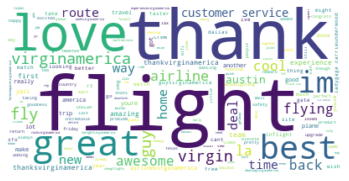

In [96]:
#define positive sentiment Virgin America
positive = df.loc[df['airline_sentiment'] == "positive"]
VApositive  = positive.loc[positive['airline'] == "Virgin America"]

#merge all the negative because of customer issue into one paragraph
all_description_VApositive = "".join(VApositive.text.values)

#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
#negative sentiment US Airways
create_word_cloud(all_description_VApositive)

Traveler yang memberikan sentimen positif terhadap Virgin America, melalui twitter memberikan apresiasi kepada Virgin America. Adapun topik yang banyak dibahas antara lain route (rute), customer service, time (waktu), dan lain sebagainya. Hal-hal tersebut dapat ditinjau kembali oleh pihak manajemen Virgin America agar dapat meningkatkan kualitas, atau setidaknya dapat mempertahankan kualitas sehingga dapat meningkatkan jumlah customer dan peningkatan penjualan produk mereka.

##### Wordcloud of United's Positive Sentiment 

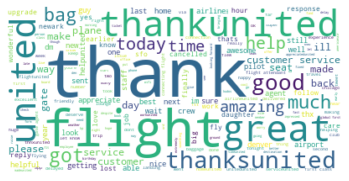

In [97]:
#define positive sentiment of United
positive = df.loc[df['airline_sentiment'] == "positive"]
Unitedpositive  = positive.loc[positive['airline'] == "United"]

#merge all the negative because of customer issue into one paragraph
all_description_Unitedpositive = "".join(Unitedpositive.text.values)

#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
#negative sentiment US Airways
create_word_cloud(all_description_Unitedpositive)

Traveler yang memberikan sentimen positif terhadap United, tentunya melalui twitter memberikan apresiasi kepada United. Adapun topik yang banyak dibahas antara lain help (bantuan), flight (penerbangan), bag (tas), dan lain sebagainya. Hal-hal tersebut dapat ditinjau kembali oleh pihak manajemen United agar dapat meningkatkan kualitas, atau setidaknya dapat dipertahankan sehingga meningkatkan jumlah customer dan peningkatan penjualan produk mereka.

### Conclusion <br>
1. Traveler airline di US banyak yang memberikan sentimen negatif dibanding sentimen positif.
2. Sentimen negatif yang banyak dibahas melalui twitter adalah customer service issue.
3. United adalah airline yang paling banyak dibahas melalui twitter oleh traveler, 69% berisi sentimen negatif dan 13% berisi sentimen positif.
4. Virgin America merupakan airline yang paling sedikit dibahas oleh traveler melalui twitter dibanding airline yang lain. Tetapi sekitar 30% twitter yang membahas tentang Virgin America merupakan sentimen positif, lebih tinggi dibanding United.
5. US Airways memiliki proporsi sentimen negatif paling banyak pada tweet yang membahas tentang mereka, yaitu sekitar 78%.

### Recommendation <br>
Sentiment analysis dapat menjadi salah satu metode yang digunakan untuk market research. Dengan sentiment analysis, kita dapat mengetahui seberapa besar awareness masyarakat dan memahami kebutuhan pelanggan terhadap produk layanan perusahaan. Di samping itu, Wordcloud mampu menunjukkan hal-hal apa saja yang menjadi perhatian pelanggan. Jangan sampai pelanggan banyak mereview hal negatif di sosial media karena dapat menurunkan awareness dan loyalitas pelanggan lainnya. Pihak manajemen dapat meninjau kembali strategi untuk mengembangkan perusahaan mereka, seperti strategi marketing maupun kualitas layanan produk yang diberikan.